# Week 5–6: Embeddings + First Evaluations
Upgrade the baseline using **sentence embeddings** (MiniLM) and compare classifiers (LR, LinearSVC).
Artifacts will be saved to `week5-6_embeddings/`.

In [1]:
from pathlib import Path
import numpy as np, pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, f1_score, accuracy_score
from sklearn.linear_model import LogisticRegression
from sklearn.svm import LinearSVC
import matplotlib.pyplot as plt
from datetime import datetime
import joblib, sys

DATA_PATH = Path("../week1-2_dataset/confidence_journal_week1-2.csv")
OUT_DIR = Path("week5-6_embeddings"); OUT_DIR.mkdir(parents=True, exist_ok=True)
assert DATA_PATH.exists(), f"Dataset not found at {DATA_PATH}"
print('Python:', sys.version)


Python: 3.13.2 (tags/v3.13.2:4f8bb39, Feb  4 2025, 15:23:48) [MSC v.1942 64 bit (AMD64)]


In [2]:
df = pd.read_csv(DATA_PATH)
assert {'text','label'} <= set(df.columns)
df['text'] = df['text'].astype(str)
df['label'] = df['label'].astype(int)
df.head()

,text,label
0,I kept rewriting the email because I was worri...,0
1,I froze during the stand‑up and stumbled over ...,0
2,I’m second‑guessing the whole plan; maybe I to...,0
3,I felt small in that conversation and didn’t s...,0
4,I looked at the to‑do list and felt like I’ll ...,0


In [3]:
try:
    from sentence_transformers import SentenceTransformer
    st_model = SentenceTransformer("sentence-transformers/all-MiniLM-L6-v2")
    print("Loaded MiniLM.")
except Exception as e:
    raise RuntimeError("Install sentence-transformers first (see README/instructions).") from e

def embed_texts(texts, batch_size=64):
    embs = []
    for i in range(0, len(texts), batch_size):
        batch = texts[i:i+batch_size].tolist() if hasattr(texts, "tolist") else texts[i:i+batch_size]
        embs.append(st_model.encode(batch, convert_to_numpy=True, show_progress_bar=False, normalize_embeddings=True))
    return np.vstack(embs)

X = df['text']
y = df['label'].values
X_train_text, X_val_text, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)
E_train = embed_texts(X_train_text)
E_val   = embed_texts(X_val_text)
E_train.shape, E_val.shape


c:\Users\earne\Downloads\neural-confidence-journal\venv\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
c:\Users\earne\Downloads\neural-confidence-journal\venv\Lib\site-packages\huggingface_hub\file_download.py:143: UserWarning: `huggingface_hub` cache-system uses symlinks by default to efficiently store duplicated files but your machine does not support them in C:\Users\earne\.cache\huggingface\hub\models--sentence-transformers--all-MiniLM-L6-v2. Caching files will still work but in a degraded version that might require more space on your disk. This warning can be disabled by setting the `HF_HUB_DISABLE_SYMLINKS_WARNING` environment variable. For more details, see https://huggingface.co/docs/huggingface_hub/how-to-cache#limitations.
To support symlinks on Windows, you either need to activate Developer Mode or to 

Loaded MiniLM.


((40, 384), (10, 384))

In [4]:
results = {}

# Logistic Regression
lr = LogisticRegression(max_iter=2000, class_weight='balanced')
lr.fit(E_train, y_train)
pred_lr = lr.predict(E_val)
results['LogReg'] = {'acc': accuracy_score(y_val, pred_lr), 'f1_macro': f1_score(y_val, pred_lr, average='macro')}

# Linear SVC
svm = LinearSVC(class_weight='balanced')
svm.fit(E_train, y_train)
pred_svm = svm.predict(E_val)
results['LinearSVC'] = {'acc': accuracy_score(y_val, pred_svm), 'f1_macro': f1_score(y_val, pred_svm, average='macro')}

results

{'LogReg': {'acc': 0.5, 'f1_macro': 0.5},
 'LinearSVC': {'acc': 0.5, 'f1_macro': 0.5}}

Best: LogReg {'acc': 0.5, 'f1_macro': 0.5}
              precision    recall  f1-score   support

           0      0.667     0.667     0.667         3
           1      0.500     0.250     0.333         4
           2      0.400     0.667     0.500         3

    accuracy                          0.500        10
   macro avg      0.522     0.528     0.500        10
weighted avg      0.520     0.500     0.483        10



'Saved to C:\\Users\\earne\\Downloads\\neural-confidence-journal\\week5-6_embeddings\\week5-6_embeddings'

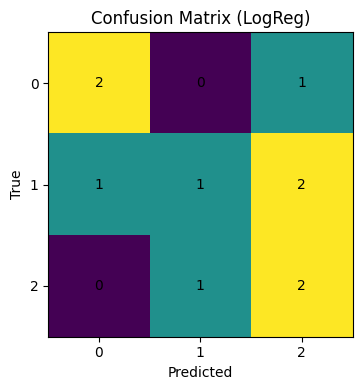

In [5]:
from pathlib import Path
import numpy as np, matplotlib.pyplot as plt

best_name = max(results, key=lambda k: results[k]['f1_macro'])
best_model = lr if best_name == 'LogReg' else svm
best_preds = pred_lr if best_name == 'LogReg' else pred_svm

print("Best:", best_name, results[best_name])
report = classification_report(y_val, best_preds, digits=3)
print(report)
cm = confusion_matrix(y_val, best_preds, labels=[0,1,2]); cm

# Save artifacts
OUT_DIR = Path("week5-6_embeddings"); OUT_DIR.mkdir(parents=True, exist_ok=True)
joblib.dump(best_model, OUT_DIR/"best_model.joblib")
(Path(OUT_DIR/"metrics.txt")).write_text(f"Results: {results}\n\nBest: {best_name}\n\n{report}", encoding="utf-8")

# Confusion matrix PNG
fig, ax = plt.subplots(figsize=(4,4))
im = ax.imshow(cm)
ax.set_title(f'Confusion Matrix ({best_name})')
ax.set_xlabel('Predicted'); ax.set_ylabel('True')
ax.set_xticks([0,1,2]); ax.set_yticks([0,1,2])
for (i,j),v in np.ndenumerate(cm): ax.text(j,i,int(v),ha="center",va="center")
fig.tight_layout(); fig.savefig(OUT_DIR/"confusion_matrix.png", dpi=150)

# Sample predictions CSV
pd.DataFrame({'text': X_val_text.values, 'true': y_val, 'pred': best_preds}).to_csv(OUT_DIR/"preds_sample.csv", index=False)
"Saved to " + str(OUT_DIR.resolve())

In [6]:
try:
    import tensorflow as tf
    from tensorflow import keras
    from tensorflow.keras import layers
    use_nn = True
    print("TensorFlow:", tf.__version__)
except Exception:
    use_nn = False
    print("TensorFlow not installed; skipping FFNN. (pip install tensorflow)")

if use_nn:
    num_classes = 3
    model = keras.Sequential([
        layers.Input(shape=(E_train.shape[1],)),
        layers.Dense(128, activation='relu'),
        layers.Dropout(0.3),
        layers.Dense(64, activation='relu'),
        layers.Dropout(0.2),
        layers.Dense(num_classes, activation='softmax')
    ])
    model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
    model.fit(E_train, y_train, validation_data=(E_val, y_val), epochs=20, batch_size=16, verbose=0)
    eval_res = model.evaluate(E_val, y_val, verbose=0)
    print("FFNN Val Acc:", eval_res[1])
    model.save("week5-6_embeddings/ffnn_embeddings.keras")

TensorFlow: 2.20.0
FFNN Val Acc: 0.4000000059604645
